In [1]:
# creat all figures
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import matplotlib.patches as mpatches
from matplotlib import rc
rc("text", usetex=False)

Plot RMSE from cross validation

In [11]:
%load_ext autoreload
%autoreload 2
from basic.plot import plot_error_cv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


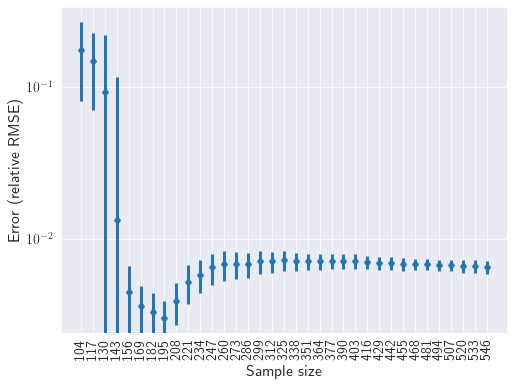

In [30]:
# Plot errors of cross-validation
filepath = '../output/paper/'
filename = 'error_cv_uniform_552.csv'
error_stats = pd.read_csv(f'{filepath}{filename}', index_col = 'index')
plot_error_cv(error_stats.iloc[2:], save_fig = True, save_path = f'{filepath}figure/',      fig_name = filename.split('.')[0])

Bar plot of sensitivity indices

<Figure size 576x432 with 0 Axes>

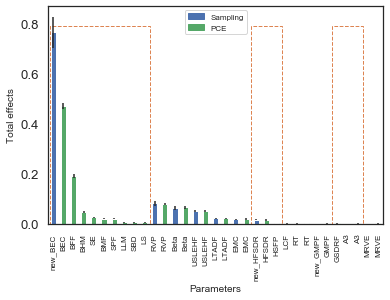

In [60]:
# sensitivity plot
filepath = '../output/paper/'
df_plot = pd.read_csv(f'{filepath}sa_fig1_0811.csv', index_col= 'Unnamed: 0')

sns.set_style('white')
current_palette = sns.color_palette()
# sns.set_color_codes(current_palette)
fig = plt.figure(figsize=(8, 6))
colors = list(np.where(df_plot.Type_num == 0, 0, 2))
colors = [current_palette[c] for c in colors]
ax = df_plot.plot(x='short_name', y='ST', kind='bar', 
                yerr='ST_conf', color=colors, legend=False, logy=False)
ax.set_ylabel('Total effects', fontsize=10)
ax.set_xlabel('Parameters', fontsize=10)
ax.tick_params(axis='x', which='major', labelsize=8)
index = [0, 20, 28]
xmin, ymin = [-0.3, 19.5, 27.5], 0
height, width = 0.79, [9.8, 3, 3]
for i  in range(len(index)):
    ax.add_patch(
        mpatches.Rectangle(
            xy=(xmin[i], ymin),  # point of origin.
            width=width[i],
            height=height,
            linewidth=1,
            color=current_palette[1],
            fill=False,
            linestyle='--'
        )
)   
SPL = mpatches.Patch(color=current_palette[0], label='Sampling')
PCE_Beta = mpatches.Patch(color=current_palette[2], label='PCE')
ax.legend(handles=[SPL, PCE_Beta], fontsize=8, loc=9) 
# plt.savefig(f'{filepath}figure/sentivity_fig1.png', format='png', dpi=300, bbox_inches='tight')

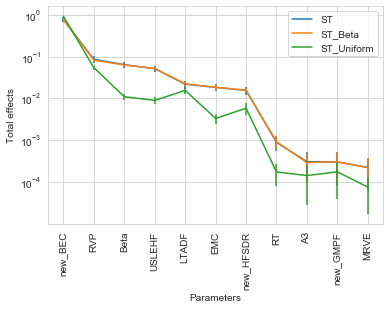

In [73]:
# plot sensitivity for PCE with 11 parameters of Beta, Uniform dists
filepath = '../output/paper/'
df_plot = pd.read_csv(f'{filepath}sa_fig2_0812.csv', index_col= 'Unnamed: 0')
cols = df_plot.columns
legend = ['ST', 'ST_Beta', 'ST_Uniform']
legend_low = [lab+'_conf_lower' for lab in legend]
legend_up = [lab+'_conf_upper' for lab in legend]
for lab in legend:
    df_plot.loc[:, f'{lab}_conf_lower'] = df_plot.loc[:, lab] - df_plot.loc[:, f'{lab}_conf_lower'] 
    df_plot.loc[:, f'{lab}_conf_upper'] = df_plot.loc[:, f'{lab}_conf_upper'] - df_plot.loc[:, lab]


sns.set_style('whitegrid')
ax = df_plot.plot(x='short_name', y=legend, kind='line', 
                yerr=df_plot.loc[:, [*legend_low, *legend_up]].T.values, 
                legend=True, logy=True, xticks=np.arange(df_plot.shape[0]))
ax.set_ylabel('Total effects', fontsize=10);
ax.set_xlabel('Parameters', fontsize=10); 
ax.set_xticklabels(df_plot.short_name.values, rotation=90);
plt.savefig(f'{filepath}figure/sentivity_fig2-2log-line.png', format='png', dpi=300, bbox_inches='tight') 

In [67]:
df_plot

,Parameters,ST,ST_conf_lower,ST_conf_upper,ST_Beta,ST_Beta_conf_lower,ST_Beta_conf_upper,ST_Uniform,ST_Uniform_conf_lower,ST_Uniform_conf_upper,short_name
0,bankErosionCoeff,0.762550,0.099928,0.114356,0.759594,0.007180,0.006195,0.916264,0.007124,0.006454,new_BEC
3,RiparianVegPercent,0.085721,0.016571,0.017165,0.081979,0.003982,0.004238,0.054049,0.005774,0.006282,RVP
7,Beta,0.063841,0.011290,0.016928,0.062540,0.003493,0.003249,0.010991,0.001943,0.002280,Beta
4,USLE_HSDR_Fine,0.051351,0.008921,0.010443,0.052003,0.002840,0.003244,0.008928,0.001611,0.001836,USLEHF
8,LongTermAvDailyFlow,0.021809,0.004800,0.005501,0.022328,0.002341,0.002537,0.015533,0.002794,0.002902,LTADF
1,eventMeanConcentration,0.018327,0.003653,0.004227,0.018395,0.002125,0.002027,0.003321,0.000877,0.000982,EMC
2,HillslopeFineSDR,0.015537,0.003284,0.003620,0.015739,0.001800,0.002105,0.005837,0.001841,0.002282,new_HFSDR
6,RainThreshold,0.000891,0.000350,0.000502,0.000921,0.000345,0.000449,0.000175,0.000093,0.000261,RT
5,A3,0.000307,0.000213,0.000504,0.000292,0.000190,0.000387,0.000143,0.000116,0.000323,A3
9,Gully_Management_Practice_Factor,0.000303,0.000217,0.000443,0.000305,0.000212,0.000390,0.000176,0.000137,0.000406,new_GMPF


Heat Map plot

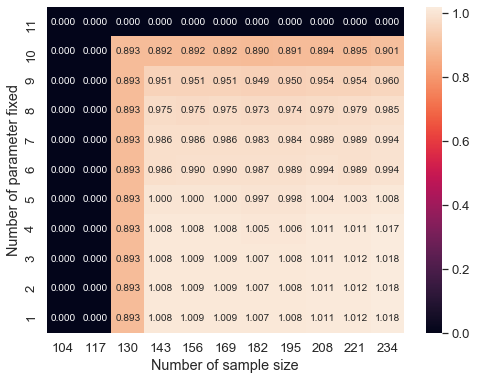

In [26]:
# heat map 
filepath = '../output/paper/error_measures/'
filename = 'conf_width_relative_95.csv'
df = pd.read_csv(f'{filepath}{filename}')
fpath_save = '../output/paper/figure/'
df.drop(columns={'Unnamed: 0'}, inplace=True)
sns.set(font_scale=1.2)
def plot_heatmap(df, save=False, save_name=None):    
    df.index = np.arange(df.shape[0], 0, -1)
    df = df.rename(columns={col: col.split('_')[1] for col in df.columns})
    fig = plt.figure(figsize=(8, 6))
    ax = sns.heatmap(df.loc[:, df.columns[0:]], annot=True, fmt=".3f", annot_kws={"size": 10})
    ax.set_xlabel('Number of sample size')
    ax.set_ylabel('Number of parameter fixed')
    if save:
        plt.savefig(f'{fpath_save}{save_name}.png', format='png', dpi=300)
plot_heatmap(df, save=True, save_name=filename.split('.')[0])

Line plot for three error measures

In [25]:
# prepare the data for plot: confidence intervals and the coefficient of variation
filepath = '../output/paper/error_measures/'
filename = ['cf_upper', 'cf_lower', 'cv', 'conf_width_relative_95', 'ks', 'pvalue']
# read statistics from the file y_uncond_stats.json
with open(f'{filepath}y_uncond_stats.json', 'r') as fp: y_uncond_stat = json.load(fp)

# get data in the corresponding column
num_params = 11
col_filter = ['nsample_156']
df = pd.DataFrame(index=np.arange(num_params), columns=filename)
x_range = [0, num_params + 1]
for f in filename:
    df[f] = pd.read_csv(f'{filepath}{f}.csv').loc[:, col_filter]
df.index = np.arange(df.shape[0], 0, -1)
df.index.name = 'Num of parameters fixed'
df.reset_index(inplace=True)
# add the one with no parameter fixed
df.loc[11, :] = [0, y_uncond_stat['cf_upper'], y_uncond_stat['cf_lower'], 
                y_uncond_stat['cv'], 1, 0, 1]

In [26]:
# add the relative change of CIs formed as the deviation to median
cf_median = (y_uncond_stat['cf_upper'] + y_uncond_stat['cf_lower']) / 2
df.loc[:, 'upper_mean'] = (df.cf_upper - y_uncond_stat['mean']) / y_uncond_stat['mean']
df.loc[:, 'lower_mean'] = (y_uncond_stat['mean'] - df.cf_lower) / y_uncond_stat['mean']
df.loc[:, 'cf_median_mean'] = (df.cf_upper - cf_median) / cf_median
df.loc[:, 'cf_cv'] = 2 * df['cv']

In [35]:
df

,Num of parameters fixed,cf_upper,cf_lower,cv,conf_width_relative_95,ks,pvalue,upper_mean,lower_mean,cf_median_mean,cf_cv
0,11.0,2.725904e+07,2.725904e+07,0.000000,0.000000,0.552028,5.516317e-117,0.003225,-0.003225,-0.029861,0.000000
1,10.0,3.518637e+07,2.207408e+07,0.079487,0.892151,0.064503,4.714835e-02,0.294978,0.187599,0.252270,0.158975
2,9.0,3.573947e+07,2.175469e+07,0.101798,0.951514,0.053400,1.423947e-01,0.315333,0.199354,0.271955,0.203596
3,8.0,3.558681e+07,2.125534e+07,0.113480,0.975103,0.039591,4.349088e-01,0.309715,0.217732,0.266522,0.226960
4,7.0,3.548077e+07,2.098877e+07,0.121500,0.986025,0.031273,7.059919e-01,0.305813,0.227542,0.262748,0.243000
5,6.0,3.555634e+07,2.101042e+07,0.131602,0.989693,0.028547,7.953990e-01,0.308594,0.226746,0.265437,0.263203
6,5.0,3.551241e+07,2.081574e+07,0.137795,0.999950,0.024931,8.905986e-01,0.306977,0.233910,0.263874,0.275590
7,4.0,3.559140e+07,2.077299e+07,0.144379,1.008233,0.013941,9.996565e-01,0.309884,0.235484,0.266685,0.288758
8,3.0,3.557027e+07,2.072878e+07,0.142170,1.009804,0.013943,9.995934e-01,0.309106,0.237111,0.265933,0.284340
9,2.0,3.557027e+07,2.072878e+07,0.142170,1.009804,0.013943,9.995934e-01,0.309106,0.237111,0.265933,0.284340


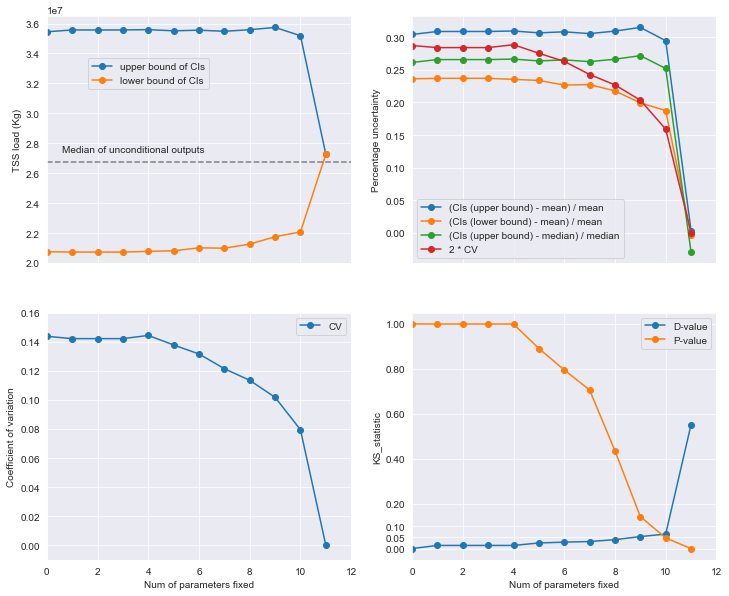

In [34]:
# Line plot
sns.set_style('darkgrid')
fs = 10
fig, axes = plt.subplots(2, 2, sharex=True)
x_col = 'Num of parameters fixed'
ax = df.plot(x=x_col, y=filename[0:2], 
            figsize=(12, 10), marker='o', ax=axes[0, 0])
             
ax.axhline(c='grey',linestyle='--', y=y_uncond_stat['median'])          
# ax.axhline(c='grey',linestyle='--', y=y_uncond_stat['cf_upper']) 
ax.text(0.05, 0.45, 'Median of unconditional outputs', transform=ax.transAxes) #c='k',

ax.set_ylabel('TSS load (Kg)')
ax.legend(['upper bound of CIs', 'lower bound of CIs'], fontsize=fs, bbox_to_anchor=(0.55, 0.85))

ax1 = df.plot(x_col, ['upper_mean', 'lower_mean', 'cf_median_mean', 'cf_cv'], marker='o', ax=axes[0, 1])
ax1.set_ylabel('Percentage uncertainty') 
ax1.legend(['(CIs (upper bound) - mean) / mean', '(CIs (lower bound) - mean) / mean', '(CIs (upper bound) - median) / median', '2 * CV'], fontsize=fs)

ax2 = df.plot(x_col, filename[2], 
            ax=axes[1, 0], marker='o')
ax2.set_ylim(-0.01, 0.16)        
ax2.set_ylabel('Coefficient of variation')
ax2.legend(['CV'], fontsize=fs)

ax3 = df.plot(x_col,filename[4:], marker='o', ax=axes[1, 1])
ax3.set_xlim(*x_range)
ax3.set_yticks([0, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0])
ax3.set_ylabel('KS_statistic')
ax3.legend(['D-value', 'P-value'], fontsize=fs) ;
ax3.set_xlabel(x_col);
fpath_save = '../output/paper/figure/'
# plt.savefig(f'{fpath_save}/measures_two_panel.png', format='png', dpi=300, bbox_inches='tight')

Line plot for showing robustness of error estimation

In [57]:
# Adaptive evaluation of error measure
filepath = '../output/paper/error_measures/'
filename = ['cf_lower_adaptive', 'cf_lower_lower_adaptive', 'cf_lower_upper_adaptive',
            'cf_upper_adaptive', 'cf_upper_lower_adaptive', 'cf_upper_upper_adaptive',                  'median_uncond_adaptive']

In [58]:
# sort the dataframe for plot
df = pd.DataFrame()
for fn in filename[:-1]:
    df[fn] = pd.read_csv(f'{filepath}{fn}.csv', index_col = 'Unnamed: 0').iloc[1]
df[filename[-1]] = pd.read_csv(f'{filepath}{filename[-1]}.csv', index_col = 'Unnamed: 0').T
cols = df.columns

In [59]:
df_ratio = pd.DataFrame(index=df.index, columns=df.columns)
for fn in filename[:-1]:
    if 'cf_lower' in fn:
        df_ratio.loc[:, fn] = (df.loc[:, cols[-1]] - df.loc[:, fn]) / df.loc[:, cols[-1]]
    else:
        df_ratio.loc[:, fn] = (df.loc[:, fn] - df.loc[:, cols[-1]]) / df.loc[:, cols[-1]]
df_ratio.loc[:, cols[-1]] = df.loc[:,]

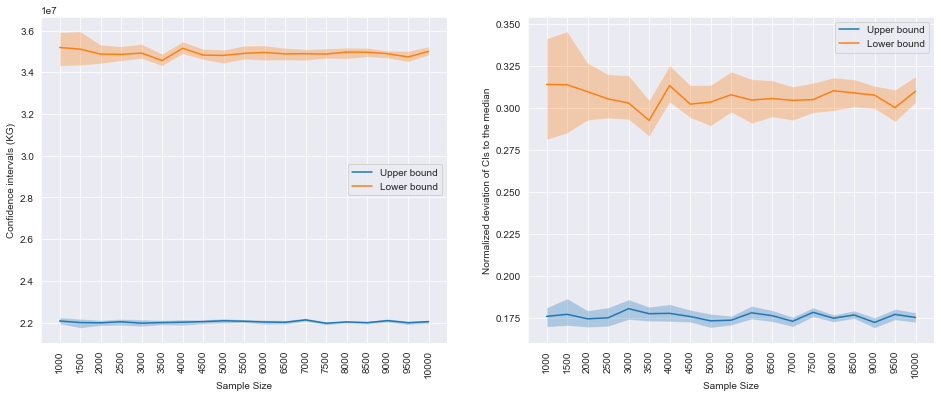

In [87]:

plt.rcParams.update({'font.size': 10})
fig, axes = plt.subplots(1, 2)
ax = df[cols[[0, 3]]].plot(figsize=(16, 6), ax=axes[0])
plt.sca(axes[0])
plt.xticks(range(len(df.index)), df.index, rotation=90)
ax.fill_between(df.index, df[cols[1]], df[cols[2]], alpha=0.3)
ax.fill_between(df.index, df[cols[4]], df[cols[5]], alpha=0.3)
ax.set_xlabel('Sample Size');
ax.set_ylabel('Confidence intervals (KG)');
ax.legend(['Upper bound', 'Lower bound'])

ax1 = df_ratio[cols[[0, 3]]].plot(ax=axes[1])
plt.sca(axes[1])
plt.xticks(range(len(df_ratio.index)), df_ratio.index, rotation=90)
ax1.fill_between(df.index, df_ratio[cols[1]], df_ratio[cols[2]], alpha=0.3)
ax1.fill_between(df.index, df_ratio[cols[4]], df_ratio[cols[5]], alpha=0.3)
ax1.set_xlabel('Sample Size');
ax1.set_ylabel('Normalized deviation of CIs to the median');
ax1.legend(['Upper bound', 'Lower bound']);
plt.savefig('../output/paper/figure/'+'conf_adaptive_two_panels.png', format='png', dpi=300, layout='tight')